## H2O-3 Regression Tutorial

[**1B. Introduction to Machine Learning with H2O-3 - Regression**](https://training.h2o.ai/products/1b-introduction-to-machine-learning-with-h2o-3-regression)に沿ったチュートリアル

[**H2O 3 - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)  
[**Python - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html)

Linux上で実施（
注意：[XGBoost(H2OXGBoostEstimator)はWindows上で動作しない](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#limitations)）

#### 目次
- [Initial Setup](#InitialSetup)
    - パッケージのインポート
    - H2Oクラスターの開始
    - データのロード
- [Start Experiment](#StartExperiment)
    - データの確認
    - 学習(train)/検証(valid)/テスト(test)データセットへの分割
    - 利用変数の定義
- [Build an XGBoost Model](#BuildXGBoostModel)
    - XGBoostモデルの作成(デフォルト設定)と学習
    - オリジナルのXGBoostとの比較（to do）
    - 学習結果の確認
    - train/validデータにおける精度確認
- [Tune the XGBoost Model with H2O GridSearch](#TuneXGBoostModelGridSearch)
    - XXX
- [Test Set Performance](#TestSetPerformance)
    - XXX
    - H2Oクラスターの停止
- [H2O-3の特徴](#H2O-3の特徴)

***

<a id='InitialSetup'></a>
### Initial Setup

In [1]:
#Import H2O and other libraries that will be used in this tutorial 
import h2o
import matplotlib as plt
%matplotlib inline

#Import the Estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

In [2]:
#> h2oパッケージのバージョン確認
print(h2o.__version__)

3.30.1.2


In [3]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/h2o_3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpldn5_65u
  JVM stdout: /tmp/tmpldn5_65u/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmpldn5_65u/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_ec2_user_1t8dmv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.677 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
#> データのロード
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


連邦住宅金融抵当公庫(Freddie Mac)が提供する約20年間(1999/1-2018/12)の住宅ローン(Fixed-Rate Mortgages)の履歴データ。金利をターゲット変数として回帰の説明に使用する。  
  
[Data Reference](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)  
[変数等データ詳細に関して](http://www.freddiemac.com/fmac-resources/research/pdf/user_guide.pdf)  
  
行数:500,137、列数:27（約80MB）

***

<a id='StartExperiment'></a>
### Start Experiment

In [5]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


ターゲット変数として利用する「金利(ORIGINAL_INTEREST_RATE)」の分布の確認

In [7]:
loan_level["ORIGINAL_INTEREST_RATE"].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.182686863799322
maxs,11.5
sigma,0.5799408623980744
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


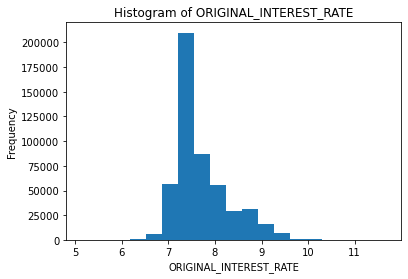

In [8]:
#> ヒストグラムによる分布の確認
loan_level["ORIGINAL_INTEREST_RATE"].hist()

In [9]:
#> 学習/検証/テストデータセットへの分割（学習 : 検証 : テスト = 70% : 15% : 15%）
train, valid, test = loan_level.split_frame([0.7, 0.15], seed=42)
print("＜train/valid/testのデータ数＞")
print( "train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows ))

＜train/valid/testのデータ数＞
train:350268 valid:74971 test:74898


In [10]:
#> ターゲット変数、特徴量の定義
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))
print(x)

['LOAN_PURPOSE', 'POSTAL_CODE', 'ORIGINAL_LOAN_TERM', 'ORIGINAL_UPB', 'CREDIT_SCORE', 'NUMBER_OF_BORROWERS', 'SELLER_NAME', 'OCCUPANCY_STATUS', 'CHANNEL', 'PROPERTY_STATE', 'METROPOLITAN_STATISTICAL_AREA', 'SERVICER_NAME', 'ORIGINAL_LOAN_TO_VALUE', 'FIRST_TIME_HOMEBUYER_FLAG', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'NUMBER_OF_UNITS', 'PROPERTY_TYPE', 'ORIGINAL_DEBT_TO_INCOME_RATIO']


In [11]:
loan_level[x].describe()

Rows:500137
Cols:18




,LOAN_PURPOSE,POSTAL_CODE,ORIGINAL_LOAN_TERM,ORIGINAL_UPB,CREDIT_SCORE,NUMBER_OF_BORROWERS,SELLER_NAME,OCCUPANCY_STATUS,CHANNEL,PROPERTY_STATE,METROPOLITAN_STATISTICAL_AREA,SERVICER_NAME,ORIGINAL_LOAN_TO_VALUE,FIRST_TIME_HOMEBUYER_FLAG,ORIGINAL_COMBINED_LOAN_TO_VALUE,NUMBER_OF_UNITS,PROPERTY_TYPE,ORIGINAL_DEBT_TO_INCOME_RATIO
type,enum,int,int,int,int,int,enum,enum,enum,enum,int,enum,int,enum,int,int,enum,int
mins,,600.0,301.0,8000.0,300.0,1.0,,,,,10180.0,,6.0,,6.0,1.0,,1.0
mean,,55490.8571382869,359.8554696013299,136493.48478516805,712.5362124215468,1.6302946648262713,,,,,30777.82473929504,,75.71071405720141,,76.0535707144633,1.0288902574110184,,32.91754051870545
maxs,,99900.0,362.0,578000.0,839.0,2.0,,,,,49740.0,,100.0,,180.0,4.0,,65.0
sigma,,29505.38225880303,1.9082507104186504,60968.74306564561,54.79126197408813,0.48272535304031594,,,,,11333.401144164478,,14.937717088968643,,15.139986048512673,0.21839057355939082,,11.111799994455248
zeros,,0,0,0,0,0,,,,,0,,0,,0,0,,0
missing,0,31,0,0,2711,247,0,0,0,0,70149,0,9,0,13,3,0,14929
0,P,26100.0,320.0,162000.0,669.0,2.0,Other sellers,O,R,WV,nan,Other servicers,80.0,N,80.0,1.0,SF,33.0
1,N,45200.0,360.0,53000.0,732.0,1.0,Other sellers,O,R,OH,17140.0,Other servicers,25.0,N,25.0,1.0,SF,10.0
2,P,44700.0,319.0,133000.0,679.0,1.0,Other sellers,O,R,OH,15940.0,Other servicers,91.0,N,91.0,1.0,SF,48.0


***

<a id='BuildXGBoostModel'></a>
### Build an XGBoost Model

[**XGBoost - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#xgboost)  
[**H2OXGBoostEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator)
  
H2O XGBoostはH2Oクラスター上でオリジナルのXGBoost動作させるようビルドされたもの。カテゴリ変数の自動Encodingといった処理も含まれている。

オリジナルのXGBoostの[ドキュメンテーション](https://xgboost.readthedocs.io/en/latest/#)

In [12]:
xgb = H2OXGBoostEstimator(seed=42, 
                          model_id='XGBoost', 
                          nfolds=0, 
                          keep_cross_validation_predictions=False)

%time xgb.train(x=x, y=y, training_frame=train, validation_frame=valid)    # 注：Windowsではサポートされていない

xgboost Model Build progress: |███████████████████████████████████████████| 100%
CPU times: user 302 ms, sys: 21 ms, total: 323 ms
Wall time: 26.5 s


- train時にvalidation_frameを指定してホールドアウト法になるので、nfolds=0、keep_cross_validation_predictions=False(それぞれデフォルト)としている

In [13]:
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost


Model Summary: 


,number_of_trees
,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.17744636323081306
RMSE: 0.4212438287154045
MAE: 0.30712844420662655
RMSLE: 0.04987056256391179
Mean Residual Deviance: 0.17744636323081306

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.18013989282125126
RMSE: 0.4244289019626859
MAE: 0.3108204587914598
RMSLE: 0.0503052982338251
Mean Residual Deviance: 0.18013989282125126

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2020-09-14 16:50:10,0.073 sec,0.0,6.7088631,6.6836794,45.0088439,6.7047501,6.6798046,44.9536733
,2020-09-14 16:50:12,2.202 sec,1.0,4.7104733,4.6786978,22.1885588,4.7073544,4.6757908,22.1591850
,2020-09-14 16:50:12,2.951 sec,2.0,3.3168272,3.2752196,11.0013425,3.3139314,3.2725993,10.9821415
,2020-09-14 16:50:13,3.531 sec,3.0,2.3488131,2.2927392,5.5169229,2.3462673,2.2904798,5.5049702
,2020-09-14 16:50:14,4.108 sec,4.0,1.6810353,1.6051706,2.8258796,1.6786024,1.6031085,2.8177062
,2020-09-14 16:50:14,4.707 sec,5.0,1.2265317,1.1245445,1.5043799,1.2244424,1.1227758,1.4992593
,2020-09-14 16:50:18,8.872 sec,15.0,0.4526525,0.3278245,0.2048943,0.4522328,0.3289853,0.2045145
,2020-09-14 16:50:22,12.882 sec,24.0,0.4384250,0.3211508,0.1922165,0.4389171,0.3229872,0.1926482
,2020-09-14 16:50:27,17.761 sec,35.0,0.4292344,0.3136409,0.1842421,0.4305375,0.3162474,0.1853626
,2020-09-14 16:50:34,24.084 sec,49.0,0.4215230,0.3073758,0.1776816,0.4246206,0.3110081,0.1803027



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.NORWESTMORTGAGE,INC",25657.9960938,1.0,0.2391252
OCCUPANCY_STATUS.I,7086.1391602,0.2761766,0.0660408
ORIGINAL_UPB,6440.5112305,0.2510138,0.0600237
ORIGINAL_LOAN_TO_VALUE,5813.7905273,0.2265879,0.0541829
LOAN_PURPOSE.P,4025.8632812,0.1569048,0.0375199
---,---,---,---
PROPERTY_STATE.OK,0.8522186,0.0000332,0.0000079
PROPERTY_STATE.ME,0.5269806,0.0000205,0.0000049
PROPERTY_STATE.MT,0.5000267,0.0000195,0.0000047
PROPERTY_STATE.KS,0.0765716,0.0000030,0.0000007


In [14]:
#> 推定したモデルの設定やハイパーパラメータの確認
xgb.actual_params

{'model_id': 'XGBoost',
 'training_frame': 'py_11_sid_9a90',
 'validation_frame': 'py_12_sid_9a90',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'ORIGINAL_INTEREST_RATE',
 'ignored_columns': ['MATURITY_DATE',
  'LOAN_SEQUENCE_NUMBER',
  'MORTGAGE_INSURANCE_PERCENTAGE',
  'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'PREPAID',
  'FIRST_PAYMENT_DATE',
  'PRODUCT_TYPE',
  'DELINQUENT'],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'stopping_rounds': 0,
 'stopping_metric': None,
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': 42,
 'distribution': 'gaussian',
 'tweedie_power': 1.5,
 'categorical_encoding': 'OneHotInternal',
 'quiet_mode': True,
 'checkpoint': None,
 'export_checkpoints_dir': None,
 'ntrees': 50,
 'max_depth': 6,
 'min_rows': 1.0,
 'm

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#defining-an-xgboost-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator)
- デフォルト設定の確認の場合 `xgb.params`, `xgb.default_params`

オリジナルのXGBoostとの比較
- XXX

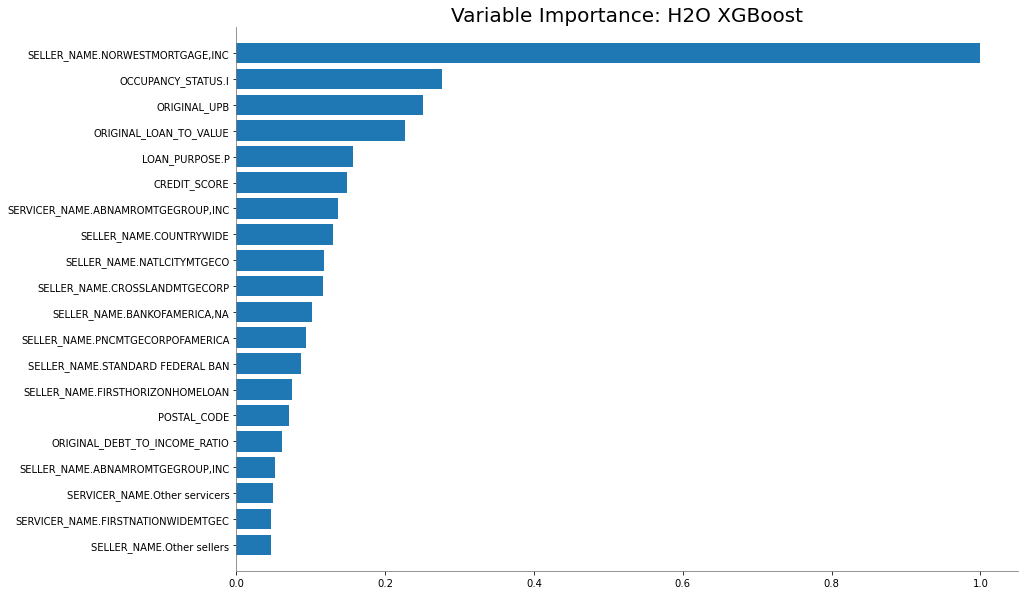

In [15]:
#> 変数重要度の表示
xgb.varimp_plot(20)

- 値自体を取得する場合 `xgb.varimp()`
- H2ORandomForestEstimatorやH2OGradientBoostingEstimatorと異なり、カテゴリ変数はone-hot encodingされた形式で表示

In [16]:
#> validデータに対する予測を実施
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.head(5)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict
7.20097
6.87724
7.0235
7.25526
7.02648


In [17]:
#> 実測値との比較
xgb_def_pred.cbind(valid['ORIGINAL_INTEREST_RATE'])

predict,ORIGINAL_INTEREST_RATE
7.20097,5.875
6.87724,6.75
7.0235,7.75
7.25526,6.625
7.02648,6.75
7.38137,7
6.8168,7
7.40214,7
7.06643,7.25
7.00728,7


In [18]:
#> validデータでの結果の取得
default_xgb_per = xgb.model_performance(valid)

In [36]:
print('RMSE on train data: ', xgb.rmse())
print('RMSE on valid data: ', default_xgb_per.rmse())

RMSE on train data:  0.4212438287154045
RMSE on valid data:  0.4244289019626859


***

<a id='BuildDeepLearningModel'></a>
### Build a Deep Learning Model

[**Deep Learning (Neural Networks) - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html)  
[**H2ODeepLearningEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)
  
H2O-3では通常のFeedforward Neural Networkのみサポート（CNNやRNNの実装はない）

In [20]:
dl = H2ODeepLearningEstimator(seed=42, 
                              model_id='DL',
                              nfolds= 0, 
                              keep_cross_validation_predictions = False)

%time dl.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 1.51 s, sys: 54.2 ms, total: 1.56 s
Wall time: 6min 5s


In [21]:
dl

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 73,601 weights/biases, 880.4 KB, 3,512,620 training samples, mini-batch size 1


,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,165,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0552208,0.2135490,0.0,-0.0142599,0.1664219,-0.0233338,0.2599651
,3,200,Rectifier,0.0,0.0,0.0,0.0492105,0.0504840,0.0,-0.0499868,0.1322242,-0.0508985,0.4922751
,4,1,Linear,,0.0,0.0,0.0012871,0.0009825,0.0,0.0091470,0.0856143,1.0714746,0.0000000




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.20926922642531118
RMSE: 0.4574595352873423
MAE: 0.3254869601038534
RMSLE: 0.05427338116670065
Mean Residual Deviance: 0.20926922642531118

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.21270922233498124
RMSE: 0.4612041005183944
MAE: 0.32924638230257997
RMSLE: 0.05465519659426862
Mean Residual Deviance: 0.21270922233498124

Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
,2020-09-14 16:56:21,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2020-09-14 16:56:27,12.292 sec,2002 obs/sec,0.0330861,1,11589.0,0.5662623,0.3206530,0.4062088,0.0240051,0.5646828,0.3188666,0.4051904,0.0449786
,2020-09-14 16:57:29,1 min 14.677 sec,7791 obs/sec,1.3780420,41,482684.0,0.5037729,0.2537871,0.3653088,0.2275295,0.5004943,0.2504946,0.3638473,0.2497563
,2020-09-14 16:58:32,2 min 15.601 sec,9256 obs/sec,3.1193400,93,1092605.0,0.4942858,0.2443185,0.3554590,0.2563500,0.4950005,0.2450255,0.3566058,0.2661365
,2020-09-14 16:59:20,3 min 4.480 sec,9927 obs/sec,4.5927775,137,1608703.0,0.4734785,0.2241819,0.3399320,0.3176412,0.4775797,0.2280824,0.3431752,0.3168819
,2020-09-14 17:00:10,3 min 54.047 sec,10397 obs/sec,6.1368352,183,2149537.0,0.4574595,0.2092692,0.3254870,0.3630320,0.4612041,0.2127092,0.3292464,0.3629254
,2020-09-14 17:00:59,4 min 43.488 sec,10706 obs/sec,7.6793912,229,2689845.0,0.4742920,0.2249529,0.3469002,0.3152944,0.4767379,0.2272791,0.3500596,0.3192879
,2020-09-14 17:01:49,5 min 33.208 sec,10950 obs/sec,9.2559297,276,3242056.0,0.4820414,0.2323639,0.3574094,0.2927370,0.4845390,0.2347780,0.3604150,0.2968283
,2020-09-14 17:02:16,5 min 59.821 sec,11052 obs/sec,10.0283783,299,3512620.0,0.4635144,0.2148456,0.3362814,0.3460588,0.4687721,0.2197473,0.3401448,0.3418459
,2020-09-14 17:02:21,6 min 4.717 sec,11052 obs/sec,10.0283783,299,3512620.0,0.4574595,0.2092692,0.3254870,0.3630320,0.4612041,0.2127092,0.3292464,0.3629254



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.ABNAMROMTGEGROUP,INC",1.0,1.0,0.0132311
"SELLER_NAME.NORWESTMORTGAGE,INC",0.9465132,0.9465132,0.0125234
SELLER_NAME.WELLSFARGOHOMEMORTGA,0.9091915,0.9091915,0.0120296
SELLER_NAME.BISHOPSGATERESIDENTI,0.8581580,0.8581580,0.0113543
SELLER_NAME.Other sellers,0.8441141,0.8441141,0.0111685
---,---,---,---
PROPERTY_TYPE.missing(NA),0.0,0.0,0.0
CHANNEL.missing(NA),0.0,0.0,0.0
LOAN_PURPOSE.missing(NA),0.0,0.0,0.0
OCCUPANCY_STATUS.missing(NA),0.0,0.0,0.0


In [23]:
#> 推定したモデルの設定やハイパーパラメータの確認
dl.actual_params

{'model_id': 'DL',
 'training_frame': 'py_11_sid_9a90',
 'validation_frame': 'py_12_sid_9a90',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'ORIGINAL_INTEREST_RATE',
 'ignored_columns': ['MATURITY_DATE',
  'LOAN_SEQUENCE_NUMBER',
  'MORTGAGE_INSURANCE_PERCENTAGE',
  'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'PREPAID',
  'FIRST_PAYMENT_DATE',
  'PRODUCT_TYPE',
  'DELINQUENT'],
 'ignore_const_cols': True,
 'score_each_iteration': False,
 'weights_column': None,
 'offset_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_hit_ratio_k': 0,
 'checkpoint': None,
 'pretrained_autoencoder': None,
 'overwrite_with_best_model': True,
 'use_all_factor_levels': True,
 'standardize': True,
 'activation': 'Rectifier',
 'hidden': [200, 200],
 '

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#defining-a-deep-learning-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)
- デフォルト設定の確認の場合 `dl.params`, `dl.default_params`

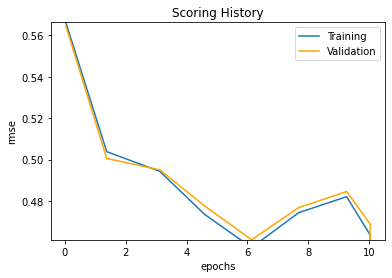

In [26]:
#> 学習の履歴の表示
dl.plot()

In [27]:
print("epochs = ", dl.params['epochs'])

epochs =  {'default': 10.0, 'actual': 10.0, 'input': 10.0}


- デフォルトのエポック数は10

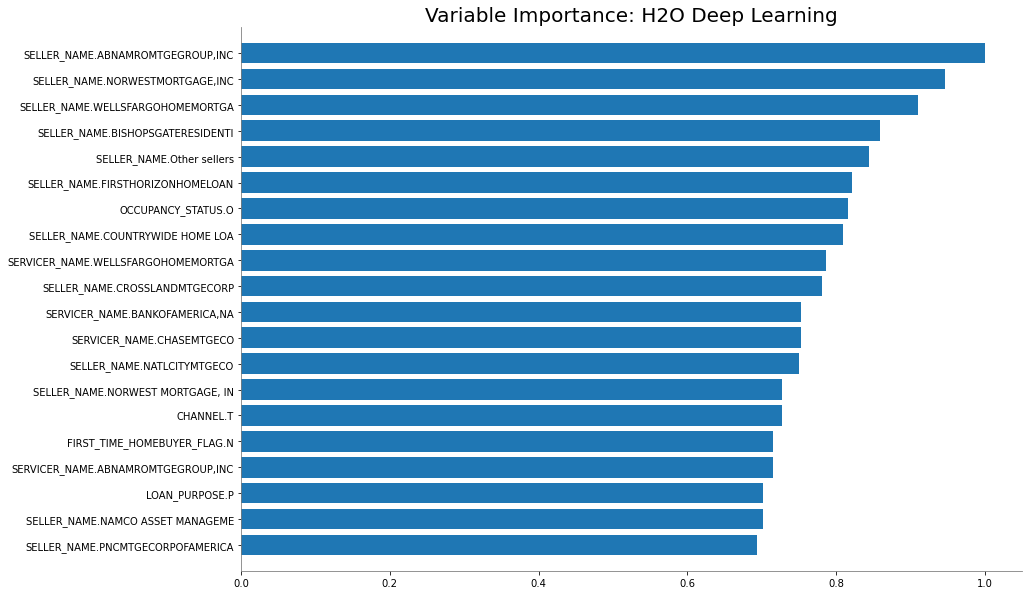

In [33]:
#> 変数重要度の表示
dl.varimp_plot(20)

- 変数重要度は"Gedeon method"により算出（[FAQ](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#faq)に回答あり）

In [34]:
#> validデータでの結果の取得
default_dl_per = dl.model_performance(valid)

In [37]:
print('RMSE on train data: ', dl.rmse())
print('RMSE on valid data: ', default_dl_per.rmse())

RMSE on train data:  0.4574595352873423
RMSE on valid data:  0.4612041005183944


その他NN特有の仕様に関する[FAQ](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#faq)

***

<a id='TuneXGBoostModelGridSearch'></a>
### Tune the XGBoost Model with H2O GridSearch

In [38]:
#> H2Oクラスターの終了
h2o.cluster().shutdown()

H2O session _sid_9a90 closed.


***
to do
- native xgboostとの比較